# Predicting Registered Voter Participation in Union County NC in the 2020 General Election

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

# OBTAIN

In [1]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

In [2]:
## Import functions made specifically for this project
from capstone_functions import *

In [3]:
## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tzlocal import get_localzone
import plotly.express as px

In [4]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [5]:
## Define the year for this notebook
year=2020

In [6]:
## Whether or not to display all plotly figures
show_plotly = False

In [7]:
## Import and preview dataset
elec_df = pd.read_csv('Data/UC_gen_2020.gz',
                     dtype={'voting_method': str})
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
0,AA100547,0,65.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,REP,M,1955,2014-03-31,W,UN,28079.0,5514 BEVERLY DR,INDIAN TRAIL,NC,Y,016,016,9.0,20B,20C,35.0,69.0,4.0
1,AA108801,0,57.0,NaN,No Vote,0.0,0.0,0.0,No Vote,UNA,M,1963,2016-11-04,W,NL,28173.0,4221 OXFORD MILL RD,WAXHAW,MA,Y,020B,020B,9.0,20B,20C,35.0,68.0,6.0
2,AA109481,0,47.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,F,1973,2020-03-19,W,NL,28173.0,1013 LYDNEY CIR,WAXHAW,MN,Y,020A,020A,9.0,20B,20C,35.0,68.0,2.0
3,AA112504,0,72.0,NaN,No Vote,0.0,0.0,0.0,No Vote,REP,F,1948,2012-10-26,W,NL,28112.0,4325 WOLF POND RD,MONROE,NY,Y,024,024,9.0,20B,20C,35.0,55.0,2.0
4,AA114763,0,53.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,DEM,F,1967,2012-08-13,B,UN,28104.0,4002 LAWRENCE DANIEL DR,MATTHEWS,NC,Y,037A,037A,9.0,20B,20C,35.0,69.0,5.0


# SCRUB

In [8]:
elec_df.duplicated(subset=['ncid']).sum()

0

In [9]:
## Check df metadata
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168070 entries, 0 to 168069
Data columns (total 28 columns):
ncid                  168070 non-null object
no_vote_his           168070 non-null int64
birth_age_adj         168070 non-null float64
voting_method         131483 non-null object
Gen_2020              168070 non-null object
vote_early            168070 non-null float64
vote_by_mail          168070 non-null float64
vote_curbside         168070 non-null float64
Pri_2020              168070 non-null object
party_cd              168070 non-null object
gender_code           168070 non-null object
birth_year            168070 non-null int64
registr_dt            168070 non-null object
race_code             168070 non-null object
ethnic_code           168070 non-null object
zip_code              168067 non-null float64
res_street_address    168070 non-null object
res_city_desc         168067 non-null object
birth_state           127298 non-null object
drivers_lic           168070 no

> Columns with missing values:
* `voting_method`: missing values are all cases where the individual did not cast a vote in this election
* `zip_code`: investigate filling in the 3 missing values based on provided address
* `res_city_desc`: same as for `zip_code`
* `birth_state`: with so many values missing, probably want to make 'missing' its own category for this feature

> Column dtypes:
* `registr_dt`: recast as datetime
* `zip_code`: likely more useful to treat as a categorical variable rather than as numeric
* `drivers_lic`: change from Y or N to 1 or 0

In [10]:
## Fill null values in voting_method with 'No Vote'
elec_df['voting_method'].fillna(value='No Vote', inplace=True)

In [11]:
## Fill null values in birth_state with 'Missing'
elec_df['birth_state'].fillna(value='Missing', inplace=True)

In [12]:
## Check records with missing zip_code
elec_df.loc[elec_df['zip_code'].isna()]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
66460,EF173508,0,26.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Early,REP,M,1994,2016-09-26,W,UN,NaN,CONFIDENTIAL,NaN,NC,Y,017A,017A,9.0,20B,20C,35.0,68.0,3.0
84648,EF203192,0,59.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,UNA,F,1961,2016-05-25,W,NL,NaN,CONFIDENTIAL,NaN,PA,Y,029C,029C,9.0,20B,20C,35.0,68.0,5.0
123136,EF35182,0,62.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,REP,F,1958,1991-03-15,W,NL,NaN,CONFIDENTIAL,NaN,NC,Y,030,030,9.0,20B,20C,35.0,69.0,1.0


> These three records missing `zip_code` also correspond to the three records missing `res_city_desc`, most likely because the residential address is confidential for these individuals. These records will be lumped under the 'Other' category for the less frequently appearing cities created to avoid issues with high cardinality and rare labels.

In [13]:
## Change drivers_lic to binary indicator
elec_df['drivers_lic_bin'] = np.where(elec_df['drivers_lic']=='Y', 1, 0)

In [14]:
## Recast zip_code as category
elec_df['zip_code'] = elec_df['zip_code'].astype('category')

In [15]:
## Recast registr_dt as datetime variable
elec_df['registr_dt'] = pd.to_datetime(elec_df['registr_dt'])

# EXPLORE

## Categorical Variables

In [16]:
check_unique('voting_method', elec_df)

,count,%
ABSENTEE ONESTOP,88137,52.44
No Vote,36587,21.77
IN-PERSON,19813,11.79
ABSENTEE BY MAIL,19647,11.69
ABSENTEE CURBSIDE,2951,1.76
PROVISIONAL,380,0.23
TRANSFER,353,0.21
CURBSIDE,202,0.12


> Almost as many people who voted in person on election day voted by mail, suggesting mail-in votes may be better treated as a separate category for the 2020 election. This would also help to break down the majority class of 'Early' to represent a smaller portion of the whole. Below I create a new column 'vote_cat'.

In [17]:
## Group original vote methods into more general categories in a new variable
 # Map the original categories to new ones
vote_method_map = {'ABSENTEE ONESTOP': 'Early',
                   'IN-PERSON': 'Election Day',
                   'ABSENTEE BY MAIL': 'Mail',
                   'ABSENTEE CURBSIDE': 'Early',
                   'TRANSFER': 'Other',
                   'PROVISIONAL': 'Other',
                   'CURBSIDE': 'Election Day',
                   'No Vote': 'No Vote'}

# Apply the map to create new vote_method_cat column
elec_df['vote_cat'] = elec_df['voting_method'].map(vote_method_map)

check_unique('vote_cat', elec_df)

,count,%
Early,91088,54.20
No Vote,36587,21.77
Election Day,20015,11.91
Mail,19647,11.69
Other,733,0.44


In [18]:
check_unique('Gen_2020', elec_df)

,count,%
Early,110735,65.89
No Vote,36587,21.77
Election Day,20015,11.91
Other,733,0.44


> The 'Other' category is made up of only 733 individuals that voted with either a provisional or transfer ballot. Need to consider dropping this extremely rare category or somehow adding those records into one of the other categories.

In [19]:
check_unique('Pri_2020', elec_df)

,count,%
No Vote,124810,74.26
Election Day,25825,15.37
Early,17122,10.19
Other,313,0.19


> 'Other' category also extremely rare for `Pri_2020` as well. If this is used as a predictor, consider changing to a binary variable indicating simply whether or not the person voted in the Primary.

In [20]:
check_unique('party_cd', elec_df)

,count,%
REP,69079,41.10
UNA,57488,34.20
DEM,40340,24.00
LIB,995,0.59
CST,96,0.06
GRE,72,0.04


> LIB, CST, and GRE extremely rare within the county. Need to deal with this in some way, but grouping into a single 'Rare' category won't necessarily solve the issue since that would still represent barely more than 0.5% of voters in this election. It could make sense to combine these three parties with UNA (unaffiliated) to simply represent voters that do not align with one of the two major parties.

In [21]:
check_unique('gender_code', elec_df)

,count,%
F,80522,47.91
M,72454,43.11
U,15094,8.98


In [22]:
check_unique('race_code', elec_df)

,count,%
W,119683,71.21
B,19182,11.41
U,18823,11.20
O,6115,3.64
A,2930,1.74
M,905,0.54
I,426,0.25
P,6,0.00


> The most infrequent categories (Other, Asian, Multiple, Native American, Pacific Islander/Native Hawaiian) each represent less than 5% of voters. To deal with these rare labels, it is probably best from a modeling standpoint to group them all under 'Other'.

In [23]:
check_unique('ethnic_code', elec_df)

,count,%
NL,123992,73.77
UN,37163,22.11
HL,6915,4.11


> Voters that chose to identify themselves as Hispanic or Latino represent less than 5% of voters. Check below to see how disclosed racial and ethnic identities intersect.

In [24]:
## Investigate how race intersects with ethnic code
for code in elec_df['ethnic_code'].unique():
    print('*****{}*****'.format(code))
    display(elec_df.loc[elec_df['ethnic_code']==code]['race_code'].value_counts().to_frame())
    print()

*****UN*****


,race_code
U,16769
W,14871
B,3931
A,810
O,464
M,228
I,87
P,3



*****NL*****


,race_code
W,103316
B,15162
O,2312
A,2110
U,383
M,380
I,328
P,1



*****HL*****


,race_code
O,3339
U,1671
W,1496
M,297
B,89
I,11
A,10
P,2


> Patterns of intersection between race and ethnicity are somewhat unclear. The majority of voters that chose not to disclose their race also chose not to disclose their ethnicity (16,769 out of 37,163). The majority of voters that identified themselves as Hispanic or Latino when registering listed their race as 'Other'(3,339 out of 6,915), with the next most frequent category being 'Undesignated' (1,671 out of 6,915), then 'White' (1,496 out of 6,915). As such, I am uncertain how useful this feature will be as a predictor, especially given that the 'HL' category is so rare.

In [25]:
check_unique('zip_code', elec_df)

,count,%
28173.0,47609,28.33
28110.0,34719,20.66
28079.0,28195,16.78
28104.0,25603,15.23
28112.0,18032,10.73
28103.0,7299,4.34
28174.0,5734,3.41
28227.0,396,0.24
28105.0,237,0.14
28133.0,155,0.09


> Seven of the 12 zip codes are rare labels (each representing less than 5% of the voters). It may be best to use grouped cities as a predictor (see immediately below) rather than zip codes, especially since the two will be highly correlated.

In [26]:
check_unique('res_city_desc', elec_df)

,count,%
MONROE,52751,31.39
WAXHAW,47609,28.33
INDIAN TRAIL,28195,16.78
MATTHEWS,25840,15.37
MARSHVILLE,7299,4.34
WINGATE,5734,3.41
CHARLOTTE,396,0.24
PEACHLAND,155,0.09
MIDLAND,86,0.05
NaN,3,0.00


> There are several rare labels, so if `res_city_desc` is to be used as a predictor, cities besides Monroe, Waxhaw, Indian Trail, and Matthews should probably be combined into an 'Other' category.

In [27]:
check_unique('birth_state', elec_df)

,count,%
NC,46367,27.59
Missing,40772,24.26
NY,13211,7.86
OC,10042,5.97
SC,4753,2.83
NJ,4492,2.67
OH,4336,2.58
PA,4334,2.58
FL,3786,2.25
CA,3351,1.99


> The majority of `birth_state` labels are rare categories (less than 5% of voters). Some of the codes do not appear to be U.S. states or territories. These rare labels could be dealt with in a couple ways. They could all be grouped into an 'Other' category, or they could be grouped according to geographic region of the U.S. with an additional category for naturalized U.S. citizens.

In [28]:
check_unique('drivers_lic', elec_df)

,count,%
Y,152984,91.02
N,15086,8.98


## Group Rare Categories

In [29]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2020 election or not
elec_df['Gen_2020_binary'] = np.where(elec_df['Gen_2020']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Gen_2020_binary', elec_df)

,count,%
1,131483,78.23
0,36587,21.77


In [30]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2020 election or not
elec_df['Pri_2020_binary'] = np.where(elec_df['Pri_2020']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Pri_2020_binary', elec_df)

,count,%
0,124810,74.26
1,43260,25.74


In [31]:
## Create new column grouping most infrequent party categories (<5% of voters)
  ## into same group as those who are unaffiliated
elec_df['party_grp'] = np.where(elec_df['party_cd'].isin(['REP', 'DEM']),
                                elec_df['party_cd'].str.title(), 'Other')

## Check distribution
check_unique('party_grp', elec_df)

,count,%
Rep,69079,41.1
Other,58651,34.9
Dem,40340,24.0


In [32]:
## Create new column grouping most infrequent race categories (<5% of voters)
elec_df['race_grp'] = np.where(elec_df['race_code'].isin(['W', 'B', 'U']),
                               elec_df['race_code'], 'O')
race_grp_map = {'W': 'White',
                'B': 'Black',
                'U': 'Undesig.',
                'O': 'Other'}
elec_df['race_grp'] = elec_df['race_grp'].map(race_grp_map)

## Check distribution
check_unique('race_grp', elec_df)

,count,%
White,119683,71.21
Black,19182,11.41
Undesig.,18823,11.20
Other,10382,6.18


In [33]:
## Create new column grouping most infrequent cities (<5% of voters)
elec_df['city_grp'] = np.where(elec_df['res_city_desc'].isin(['MONROE', 
                                                              'WAXHAW',
                                                              'INDIAN TRAIL',
                                                              'MATTHEWS']),
                                elec_df['res_city_desc'].str.title(), 'Other')

## Check distribution
check_unique('city_grp', elec_df)

,count,%
Monroe,52751,31.39
Waxhaw,47609,28.33
Indian Trail,28195,16.78
Matthews,25840,15.37
Other,13675,8.14


In [34]:
## Create a function for grouping birth_state into U.S. Census regions, 
  ## also lumping territories and out of country into 'Other'
def get_birth_reg_census_other(state):
    
    if state in ['AS', 'GU', 'MP', 'PR', 'VI', 'OC']:
        return 'Other'
    
    # the rest of the categories are based on U.S. Census Bureau regions
    elif state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT',
                     'NJ', 'NY', 'PA']:
        return 'Northeast'
    
    elif state in ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
                     'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR',
                     'LA', 'OK', 'TX']:
        return 'South'
    
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI',
                     'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    
    elif state in ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT',
                     'WY', 'AK', 'CA', 'HI', 'OR', 'WA']:
        return 'West'
    
    else:
        return 'Missing'

In [35]:
## Create a new column grouping birth_state into U.S. Census regions,
  ## this time lumping territories and out of country into 'Other'
elec_df['birth_reg_other'] = elec_df['birth_state'].apply(get_birth_reg_census_other)
check_unique('birth_reg_other', elec_df)

,count,%
South,70810,42.13
Missing,40773,24.26
Northeast,26291,15.64
Midwest,13749,8.18
Other,10535,6.27
West,5912,3.52


## Numeric Variables

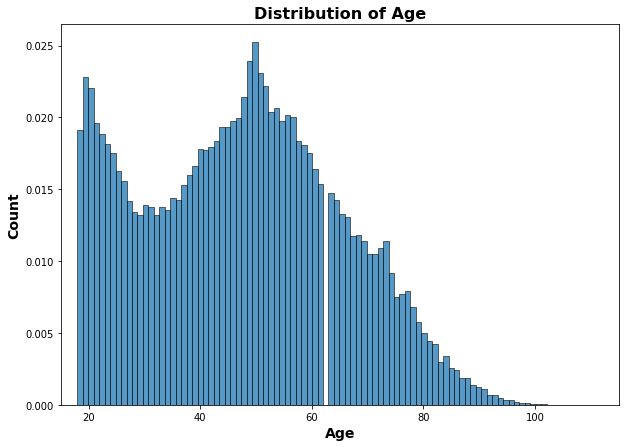

In [36]:
## Plot distribution of current age as of EOY 2020 
plt.figure(figsize=(10,7))
ax = sns.histplot(elec_df['birth_age_adj'], stat='density')
ax.set_title('Distribution of Age', fontsize=16, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')
ax.set_xlim(15,115);

## Bin Age into Generation Categories

In [37]:
## Create a function for grouping birth_year into generations
def get_generation(birth_year):
    
    if birth_year <= 1924:
        return 'Greatest'
    
    elif (birth_year > 1923) & (birth_year < 1946):
        return 'Silent'
    
    elif (birth_year > 1945) & (birth_year < 1965):
        return 'Boomer'
    
    elif (birth_year > 1964) & (birth_year < 1981):
        return 'GenX'
    
    elif (birth_year > 1980) & (birth_year < 1997):
        return 'Millennial'
    
    elif birth_year > 1996:
        return 'GenZ'

## Create a a new column grouping birth_year into generations
elec_df['generation'] = elec_df['birth_year'].apply(get_generation)
check_unique('generation', elec_df)

,count,%
GenX,53717,31.96
Boomer,44171,26.28
Millennial,38600,22.97
GenZ,19834,11.80
Silent,11595,6.90
Greatest,153,0.09


In [38]:
## Create a function for grouping birth_year into generations, 
  ## also lumping Silent in with Greatest
def get_gen_grp(birth_year):
    
    if birth_year < 1946:
        return 'Greatest-Silent'
    
    elif (birth_year > 1945) & (birth_year < 1965):
        return 'Boomer'
    
    elif (birth_year > 1964) & (birth_year < 1981):
        return 'GenX'
    
    elif (birth_year > 1980) & (birth_year < 1997):
        return 'Millennial'
    
    elif birth_year > 1996:
        return 'GenZ'

## Create a new column grouping birth_year into generations, 
  ## also lumping Silent in with Greatest
elec_df['gen_grp'] = elec_df['birth_year'].apply(get_gen_grp)
check_unique('gen_grp', elec_df)

,count,%
GenX,53717,31.96
Boomer,44171,26.28
Millennial,38600,22.97
GenZ,19834,11.80
Greatest-Silent,11748,6.99


## Load in Full Clean Dataset

In [39]:
# elec_df.to_csv('Data/UC_gen_2020_clean.gz', compression='gzip', index=False)

In [40]:
## Import and preview dataset
elec_df = pd.read_csv('Data/UC_gen_2020_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'vtd_abbrv': str
                             })
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,drivers_lic_bin,vote_cat,Gen_2020_binary,Pri_2020_binary,party_grp,race_grp,city_grp,birth_reg_other,generation,gen_grp
0,AA100547,0,65.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,REP,M,1955,2014-03-31,W,UN,28079.0,5514 BEVERLY DR,INDIAN TRAIL,NC,Y,016,016,9.0,20B,20C,35.0,69.0,4.0,1,Early,1,1,Rep,White,Indian Trail,South,Boomer,Boomer
1,AA108801,0,57.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,UNA,M,1963,2016-11-04,W,NL,28173.0,4221 OXFORD MILL RD,WAXHAW,MA,Y,020B,020B,9.0,20B,20C,35.0,68.0,6.0,1,No Vote,0,0,Other,White,Waxhaw,Northeast,Boomer,Boomer
2,AA109481,0,47.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,F,1973,2020-03-19,W,NL,28173.0,1013 LYDNEY CIR,WAXHAW,MN,Y,020A,020A,9.0,20B,20C,35.0,68.0,2.0,1,Early,1,0,Dem,White,Waxhaw,Midwest,GenX,GenX
3,AA112504,0,72.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,REP,F,1948,2012-10-26,W,NL,28112.0,4325 WOLF POND RD,MONROE,NY,Y,024,024,9.0,20B,20C,35.0,55.0,2.0,1,No Vote,0,0,Rep,White,Monroe,Northeast,Boomer,Boomer
4,AA114763,0,53.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,DEM,F,1967,2012-08-13,B,UN,28104.0,4002 LAWRENCE DANIEL DR,MATTHEWS,NC,Y,037A,037A,9.0,20B,20C,35.0,69.0,5.0,1,Early,1,1,Dem,Black,Matthews,South,GenX,GenX


In [41]:
elec_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168070 entries, 0 to 168069
Data columns (total 38 columns):
ncid                  168070 non-null object
no_vote_his           168070 non-null int64
birth_age_adj         168070 non-null float64
voting_method         168070 non-null object
Gen_2020              168070 non-null object
vote_early            168070 non-null float64
vote_by_mail          168070 non-null float64
vote_curbside         168070 non-null float64
Pri_2020              168070 non-null object
party_cd              168070 non-null object
gender_code           168070 non-null object
birth_year            168070 non-null int64
registr_dt            168070 non-null object
race_code             168070 non-null object
ethnic_code           168070 non-null object
zip_code              168067 non-null float64
res_street_address    168070 non-null object
res_city_desc         168067 non-null object
birth_state           168070 non-null object
drivers_lic           168070 no

## Registered Voter Population Summary

In [42]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'Gen_2020',
                  title='Distribution of Voting Methods in 2020 Election'))

In [43]:
if show_plotly:
    display(basic_pie(elec_df, year, 'Gen_2020',
              title='Voting Methods in 2020 Election'))

In [44]:
if show_plotly:
    fig = px.histogram(elec_df, x='birth_age_adj', nbins=50,
                       title='Distribution of Registered Voters by Age in 2020 Election',
                       labels={'birth_age_adj': 'Age'},
                       template='seaborn'
                      )
    
    fig.show()

In [45]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'gen_grp',
              title='Distribution of Registered Voters by Generation in 2020 Election'))

In [46]:
if show_plotly:
    display(basic_pie(elec_df, year, 'gen_grp',
              title='Registered Voters by Generation in 2020 Election'))

In [47]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'party_grp',
              title='Distribution of Registered Voters by Party Affiliation in 2020 Election'))

In [48]:
if show_plotly:
    display(basic_pie(elec_df, year, 'party_grp',
              title='Registered Voters by Party Affiliation in 2020 Election'))

In [49]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'race_grp',
              title='Distribution of Registered Voters by Race in 2020 Election'))

In [50]:
if show_plotly:
    display(basic_pie(elec_df, year, 'race_grp',
              title='Registered Voters by Race in 2020 Election'))

In [51]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'gender_code',
              title='Distribution of Registered Voters by Gender in 2020 Election'))

In [52]:
if show_plotly:
    display(basic_pie(elec_df, year, 'gender_code',
              title='Registered Voters by Gender in 2020 Election'))

In [53]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'birth_reg_other',
              title='Distribution of Registered Voters by Birth Region in 2020 Election'))

In [54]:
if show_plotly:
    display(basic_pie(elec_df, year, 'birth_reg_other',
              title='Registered Voters by Birth Region in 2020 Election'))

In [55]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'drivers_lic',
              title='Distribution of Registered Voters by Drivers License Possession in 2020 Election'))

In [56]:
if show_plotly:
    display(basic_pie(elec_df, year, 'drivers_lic',
              title='Possession of Drivers License by Registered Voters in 2020 Election'))

In [57]:
if show_plotly:
    display(basic_px_hist(elec_df, year, 'city_grp',
              title='Distribution of Registered Voters by City in 2020 Election'))

In [58]:
if show_plotly:
    display(basic_pie(elec_df, year, 'city_grp',
              title='Registered Voters by City in 2020 Election'))

## Relationship to Voting Method

### By Age

In [59]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'birth_age_adj', 'Gen_2020', 
            title='Distribution of Voter Age by Voting Method in 2020 Election'))

In [60]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'gen_grp', 'Gen_2020', 
            title='Voting Method by Generation'))

In [61]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gen_grp', 'Early',
              title='Early Voters by Generation'))

In [62]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gen_grp', 'Election Day',
              title='Election Day Voters by Generation'))

In [63]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gen_grp', 'No Vote',
              title='Non-Voters by Generation'))

In [64]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gen_grp', 'Other',
              title='Provisional/ Transfer Voters by Generation'))

In [65]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gen_grp', 'Gen_2020', 'GenZ',
              title='Votes by Gen Z'))

In [66]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gen_grp', 'Gen_2020', 'Millennial',
              title='Votes by Millennials'))

In [67]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gen_grp', 'Gen_2020', 'GenX',
              title='Votes by Generation X'))

In [68]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gen_grp', 'Gen_2020', 'Boomer',
              title='Votes by Baby Boomers'))

In [69]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gen_grp', 'Gen_2020', 'Greatest-Silent',
              title='Votes by Greatest and Silent Generation'))

### By Party

In [70]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'party_grp', 
            title='Voting Method by Party'))

In [71]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'party_grp', 'Early',
              title='Early Voters by Party'))

In [72]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'party_grp', 'Election Day',
              title='Election Day Voters by Party'))

In [73]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'party_grp', 'No Vote',
              title='Non-Voters by Party'))

In [74]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'party_grp', 'Other',
              title='Provisional/ Transfer Voters by Party'))

In [75]:
if show_plotly:
    display(grp_pie(elec_df, year, 'party_grp', 'Gen_2020', 'Dem',
              title='Votes by Democratic Party'))

In [76]:
if show_plotly:
    display(grp_pie(elec_df, year, 'party_grp', 'Gen_2020', 'Rep',
              title='Votes by Republican Party'))

In [77]:
if show_plotly:
    display(grp_pie(elec_df, year, 'party_grp', 'Gen_2020', 'Other',
              title='Votes by Other Voters'))

### By Race

In [78]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'race_grp',
            title='Voting Method by Race'))

In [79]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'race_grp', 'Early',
              title='Early Voters by Race'))

In [80]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'race_grp', 'Election Day',
              title='Election Day Voters by Race'))

In [81]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'race_grp', 'No Vote',
              title='Non-Voters by Race'))

In [82]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'race_grp', 'Other',
              title='Provisional/ Transfer Voters by Race'))

In [83]:
if show_plotly:
    display(grp_pie(elec_df, year, 'race_grp', 'Gen_2020', 'White',
              title='Votes by White Voters'))

In [84]:
if show_plotly:
    display(grp_pie(elec_df, year, 'race_grp', 'Gen_2020', 'Black',
              title='Votes by Black Voters'))

In [85]:
if show_plotly:
    display(grp_pie(elec_df, year, 'race_grp', 'Gen_2020', 'Undesig.',
              title='Votes by Voters of Undesignated Race'))

In [86]:
if show_plotly:
    display(grp_pie(elec_df, year, 'race_grp', 'Gen_2020', 'Other',
              title='Votes by Voters of Other Racial Backgrounds'))

### By Gender

In [87]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'gender_code', 
            title='Voting Method by Gender'))

In [88]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gender_code', 'Early',
              title='Early Voters by Gender'))

In [89]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gender_code', 'Election Day',
              title='Election Day Voters by Gender'))

In [90]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gender_code', 'No Vote',
              title='Non-Voters by Gender'))

In [91]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'gender_code', 'Other',
              title='Provisional/ Transfer Voters by Gender'))

In [92]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gender_code', 'Gen_2020', 'F',
              title='Votes by Women'))

In [93]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gender_code', 'Gen_2020', 'M',
              title='Votes by Men'))

In [94]:
if show_plotly:
    display(grp_pie(elec_df, year, 'gender_code', 'Gen_2020', 'U',
              title='Votes by Voters of Undesignated Gender'))

### By Birth Region

In [95]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'birth_reg_other', 
            title='Voting Method by Birth Region'))

In [96]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'birth_reg_other', 'Early',
              title='Early Voters by Birth Region'))

In [97]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'birth_reg_other', 'Election Day',
              title='Election Day Voters by Birth Region'))

In [98]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'birth_reg_other', 'No Vote',
              title='Non-Voters by Birth Region'))

In [99]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'birth_reg_other', 'Other',
              title='Provisional/ Transfer Voters by Birth Region'))

In [100]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'South',
              title='Votes by Voters from the South'))

In [101]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'Missing',
              title='Votes by Voters with Missing Birth Region'))

In [102]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'Northeast',
              title='Votes by Voters from the Northeast'))

In [103]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'Midwest',
              title='Votes by Voters from the Midwest'))

In [104]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'Other',
              title='Votes by Voters Born in U.S. Territories or Outside the U.S.'))

In [105]:
if show_plotly:
    display(grp_pie(elec_df, year, 'birth_reg_other', 'Gen_2020', 'West',
              title='Votes by Voters from the West'))

### By Possessing a Drivers License

In [106]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'drivers_lic', 
            title='Voting Method by Voters with and without Drivers Licenses'))

In [107]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'drivers_lic', 'Early',
              title='Early Voters by Possession of Drivers License'))

In [108]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'drivers_lic', 'Election Day',
              title='Election Day Voters by Possession of Drivers License'))

In [109]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'drivers_lic', 'No Vote',
              title='Non-Voters by Possession of Drivers License'))

In [110]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'drivers_lic', 'Other',
              title='Provisional/ Transfer Voters by Possession of Drivers License'))

In [111]:
if show_plotly:
    display(grp_pie(elec_df, year, 'drivers_lic', 'Gen_2020', 'Y',
              title='Votes by People with a Drivers License'))

In [112]:
if show_plotly:
    display(grp_pie(elec_df, year, 'drivers_lic', 'Gen_2020', 'N',
              title='Votes by People with No Drivers License'))

### By City

In [113]:
if show_plotly:
    display(grp_px_hist(elec_df, year, 'Gen_2020', 'city_grp', 
            title='Voting Method by City of Residence'))

In [114]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'city_grp', 'Early',
              title='Early Voters by City of Residence'))

In [115]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'city_grp', 'Election Day',
              title='Election Day Voters by City of Residence'))

In [116]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'city_grp', 'No Vote',
              title='Non-Voters by City of Residence'))

In [117]:
if show_plotly:
    display(grp_pie(elec_df, year, 'Gen_2020', 'city_grp', 'Other',
              title='Provisional/ Transfer Voters by City of Residence'))

In [118]:
if show_plotly:
    display(grp_pie(elec_df, year, 'city_grp', 'Gen_2020', 'Monroe',
              title='Votes by Residents of Monroe'))

In [119]:
if show_plotly:
    display(grp_pie(elec_df, year, 'city_grp', 'Gen_2020', 'Waxhaw',
              title='Votes by Residents of Waxhaw'))

In [120]:
if show_plotly:
    display(grp_pie(elec_df, year, 'city_grp', 'Gen_2020', 'Indian Trail',
              title='Votes by Residents of Indian Trail'))

In [121]:
if show_plotly:
    display(grp_pie(elec_df, year, 'city_grp', 'Gen_2020', 'Matthews',
              title='Votes by Residents of Matthews'))

In [122]:
if show_plotly:
    display(grp_pie(elec_df, year, 'city_grp', 'Gen_2020', 'Other',
              title='Votes from Other Cities in Union County'))

# MODEL

In [123]:
## Import and preview dataset
elec_df = pd.read_csv('Data/UC_gen_2020_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'vtd_abbrv': str
                             })
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,drivers_lic_bin,vote_cat,Gen_2020_binary,Pri_2020_binary,party_grp,race_grp,city_grp,birth_reg_other,generation,gen_grp
0,AA100547,0,65.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,REP,M,1955,2014-03-31,W,UN,28079.0,5514 BEVERLY DR,INDIAN TRAIL,NC,Y,016,016,9.0,20B,20C,35.0,69.0,4.0,1,Early,1,1,Rep,White,Indian Trail,South,Boomer,Boomer
1,AA108801,0,57.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,UNA,M,1963,2016-11-04,W,NL,28173.0,4221 OXFORD MILL RD,WAXHAW,MA,Y,020B,020B,9.0,20B,20C,35.0,68.0,6.0,1,No Vote,0,0,Other,White,Waxhaw,Northeast,Boomer,Boomer
2,AA109481,0,47.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,F,1973,2020-03-19,W,NL,28173.0,1013 LYDNEY CIR,WAXHAW,MN,Y,020A,020A,9.0,20B,20C,35.0,68.0,2.0,1,Early,1,0,Dem,White,Waxhaw,Midwest,GenX,GenX
3,AA112504,0,72.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,REP,F,1948,2012-10-26,W,NL,28112.0,4325 WOLF POND RD,MONROE,NY,Y,024,024,9.0,20B,20C,35.0,55.0,2.0,1,No Vote,0,0,Rep,White,Monroe,Northeast,Boomer,Boomer
4,AA114763,0,53.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,DEM,F,1967,2012-08-13,B,UN,28104.0,4002 LAWRENCE DANIEL DR,MATTHEWS,NC,Y,037A,037A,9.0,20B,20C,35.0,69.0,5.0,1,Early,1,1,Dem,Black,Matthews,South,GenX,GenX


In [124]:
## Import necessary functions/methods/classes for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

## Import classes necessary for building preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Binary Target - Vote vs. No Vote

### Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [125]:
## Create new DataFrame from the full cleaned df that only consists of 
  ## the target ('Gen_2020') and desired predictors
model_df = elec_df.copy()
model_df = model_df[['Gen_2020', 'Gen_2020_binary', 'gen_grp', 'party_grp',
                     'race_grp', 'gender_code', 'birth_reg_other',
                     'drivers_lic', 'city_grp']]

## Drop the 'Other' voting method so train-test-splits constant across
## binary and multiclass target models
  ## 'Other' represents provisional and transfer ballots. This type of
    ## vote is not so much generated by a voter's choice as it is by the 
    ## legal process of how votes may be cast.
model_df = model_df.drop(model_df.loc[model_df['Gen_2020']=='Other'].index)

## Inspect the resulting df
display(model_df.head())
len(model_df)

,Gen_2020,Gen_2020_binary,gen_grp,party_grp,race_grp,gender_code,birth_reg_other,drivers_lic,city_grp
0,Early,1,Boomer,Rep,White,M,South,Y,Indian Trail
1,No Vote,0,Boomer,Other,White,M,Northeast,Y,Waxhaw
2,Early,1,GenX,Dem,White,F,Midwest,Y,Waxhaw
3,No Vote,0,Boomer,Rep,White,F,Northeast,Y,Monroe
4,Early,1,GenX,Dem,Black,F,South,Y,Matthews


167337

In [126]:
## Check class imbalance
check_unique('Gen_2020_binary', model_df)

,count,%
1,130750,78.14
0,36587,21.86


In [127]:
## Define target variable
bin_target = 'Gen_2020_binary'

## Separate features (X) and target (y) for train-test-split
X = model_df.drop(columns=[bin_target, 'Gen_2020'], axis=1).copy()
y_bin = model_df[bin_target].copy()

In [128]:
## Define random seed to use for train-test-split and 
 ## classifiers for reproducibility
random_seed = 319

## Split the data into training and test sets prior to preprocessing
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin,
                                           test_size=0.25,
                                           random_state=random_seed)

In [129]:
## Make a list of all columns that are currently object dtype
cat_cols = list(X_train.select_dtypes('O').columns)

## Create a pipeline for one hot encoding categorical columns
cat_transformer = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown='error', 
                          sparse=False,
                          drop='if_binary'))])

## Define pipeline for preprocessing X
preprocessing = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cols)
])

## Preprocess training and test predictors (X)
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

## Get the feature names in the order they appear in preprocessed data
feature_names = preprocessing.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)
feature_names

array(['gen_grp_Boomer', 'gen_grp_GenX', 'gen_grp_GenZ',
       'gen_grp_Greatest-Silent', 'gen_grp_Millennial', 'party_grp_Dem',
       'party_grp_Other', 'party_grp_Rep', 'race_grp_Black',
       'race_grp_Other', 'race_grp_Undesig.', 'race_grp_White',
       'gender_code_F', 'gender_code_M', 'gender_code_U',
       'birth_reg_other_Midwest', 'birth_reg_other_Missing',
       'birth_reg_other_Northeast', 'birth_reg_other_Other',
       'birth_reg_other_South', 'birth_reg_other_West', 'drivers_lic_Y',
       'city_grp_Indian Trail', 'city_grp_Matthews', 'city_grp_Monroe',
       'city_grp_Other', 'city_grp_Waxhaw'], dtype=object)

### Best Model - XGBoost Classifier

#### Baseline XGBoost

-------------------------------------------------------------------
Classification Report: Baseline Binary XGBoost with Default Params
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.61      0.07      0.13      9211
        Vote       0.79      0.99      0.88     32624

    accuracy                           0.79     41835
   macro avg       0.70      0.53      0.50     41835
weighted avg       0.75      0.79      0.71     41835

-------------------------------------------------------------------
-------------------------------------------------------------------




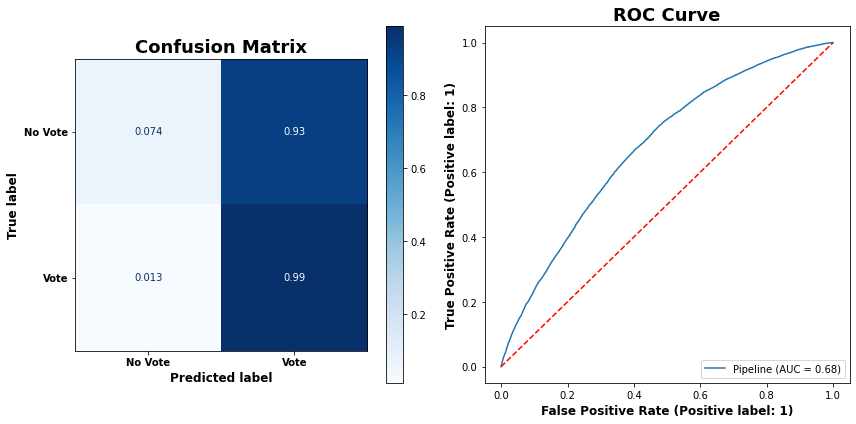

In [130]:
## Use preprocessor as the first step in modeling Pipeline 
xgb_bin = Pipeline(steps=[('preprocessing', preprocessing),
                      ('xgb', XGBClassifier(random_state=random_seed,
                                            objective='binary:logistic'))])

xgb_bin.fit(X_train, y_bin_train)

eval_bin_clf(xgb_bin, X_test, y_bin_test,
             model_descr='Baseline Binary XGBoost with Default Params');

#### Tuning XGBoost Hyperparameters

------------------------------------------------------------
***** Grid Search Started at 01/12/21 - 10:31:34 AM
------------------------------------------------------------


***** Training Completed at 01/12/21 - 10:32:34 AM

***** Total Training Time: 0:01:00.483215


Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 6, 'xgb__scale_pos_weight': 0.28, 'xgb__subsample': 0.85}


-------------------------------------------------------------------
Classification Report: Best Binary XGB Tuned for Balanced Accuracy
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.34      0.58      0.43      9211
        Vote       0.85      0.69      0.76     32624

    accuracy                           0.66     41835
   macro avg       0.60      0.63      0.60     41835
weighted avg       0.74      0.66      0.69     41835

-----------------------------

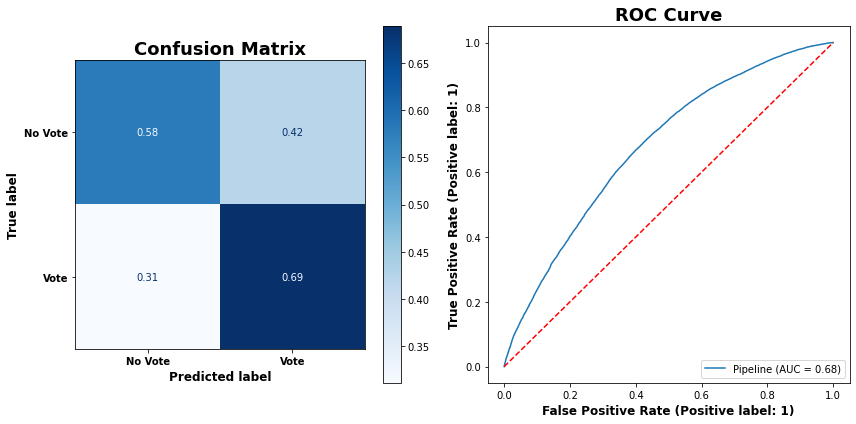

In [131]:
## Define a grid of different hyperparameter values to be tested
params = {
    'xgb__eta':[0.1],
    'xgb__max_depth':[6],
    'xgb__subsample': [0.85],
    'xgb__colsample_bytree': [0.8],
    'xgb__scale_pos_weight': [0.28],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_bin_bacc_grid = fit_grid_clf(xgb_bin, params,
                             X_train, y_bin_train,
                             X_test, y_bin_test,
                             model_descr='Best Binary XGB Tuned for Balanced Accuracy',
                             score='balanced_accuracy',
                             bin_target=True)

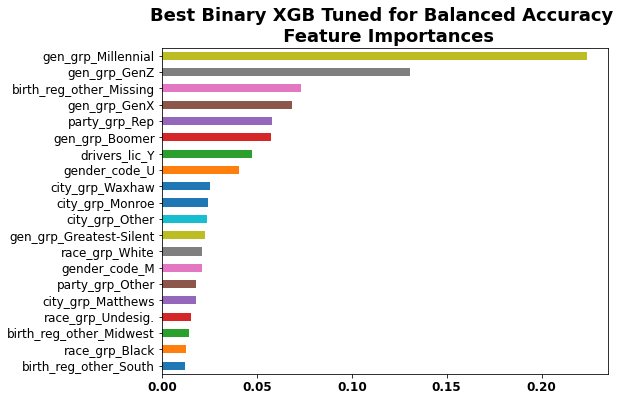

In [132]:
plot_feat_importance(xgb_bin_bacc_grid.best_estimator_, 'xgb', feature_names,
                     model_title='Best Binary XGB Tuned for Balanced Accuracy \n');

## Multiclass Target - Early, Election Day, No Vote

### Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [133]:
## Inspect model_df
display(model_df.head())
len(model_df)

,Gen_2020,Gen_2020_binary,gen_grp,party_grp,race_grp,gender_code,birth_reg_other,drivers_lic,city_grp
0,Early,1,Boomer,Rep,White,M,South,Y,Indian Trail
1,No Vote,0,Boomer,Other,White,M,Northeast,Y,Waxhaw
2,Early,1,GenX,Dem,White,F,Midwest,Y,Waxhaw
3,No Vote,0,Boomer,Rep,White,F,Northeast,Y,Monroe
4,Early,1,GenX,Dem,Black,F,South,Y,Matthews


167337

In [134]:
## Check that only the 3 target classes that represent a voter's choice remain
check_unique('Gen_2020', model_df)

,count,%
Early,110735,66.17
No Vote,36587,21.86
Election Day,20015,11.96


In [135]:
## Define target variable
multi_target = 'Gen_2020'

## Separate features (X) and target (y) for train-test-split
# X = model_df.drop(columns=[bin_target, multi_target], axis=1).copy()
## X was already defined for previous models,
  ## only need to adjust for new target
y_multi = model_df[multi_target].copy()

In [136]:
## Define random seed to use for train-test-split and 
 ## classifiers for reproducibility
random_seed = 319

## Split the data into training and test sets prior to preprocessing
  ## Random seed same as for binary modeling, so produces same X splits
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X,
                                                                y_multi,
                                                                test_size=0.25,
                                                                random_state=random_seed)

In [137]:
## Preprocess training and test target (y)
le = LabelEncoder()
y_multi_train = pd.Series(le.fit_transform(y_multi_train))
y_multi_test = pd.Series(le.transform(y_multi_test))

## Check order of classes
le.classes_

array(['Early', 'Election Day', 'No Vote'], dtype=object)

### Best Model - XGBoost with SMOTE

In [138]:
## Import necessary libraries and classes
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

### Baseline XGBoost with SMOTE

--------------------------------------------------------------------
Classification Report: Multiclass SMOTE XGBoost with Default Params
--------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.76      0.56      0.64     27591
Election Day       0.18      0.37      0.24      5033
     No Vote       0.38      0.46      0.42      9211

    accuracy                           0.51     41835
   macro avg       0.44      0.46      0.43     41835
weighted avg       0.61      0.51      0.54     41835

--------------------------------------------------------------------
--------------------------------------------------------------------




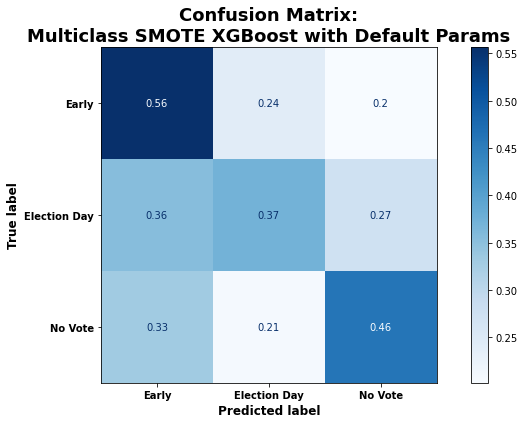

In [139]:
## Use preprocessor as the first step in modeling Pipeline,
  ## followed by SMOTE for oversampling
xgb_multi_smote = imbPipeline(steps=[
    ('preprocessing', preprocessing),
    ('sampler', SMOTE(random_state=random_seed, n_jobs=-1)),
    ('xgb', XGBClassifier(random_state=random_seed))])

xgb_multi_smote.fit(X_train, y_multi_train)

eval_classifier(xgb_multi_smote, X_test, y_multi_test,
                model_descr='Multiclass SMOTE XGBoost with Default Params');

### Tuning XGBoost with SMOTE

------------------------------------------------------------
***** Grid Search Started at 01/12/21 - 10:35:55 AM
------------------------------------------------------------


***** Training Completed at 01/12/21 - 10:41:41 AM

***** Total Training Time: 0:05:45.905893


Best Parameters:
{'sampler__k_neighbors': 3, 'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


-----------------------------------------------------------------------------
Classification Report: Best Multiclass SMOTE XGB Tuned for Balanced Accuracy
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.76      0.53      0.63     27591
Election Day       0.18      0.40      0.24      5033
     No Vote       0.38      0.46      0.42      9211

    accuracy                           0.50     41835
   macro avg       0.44      0.46      0.43     41835
weigh

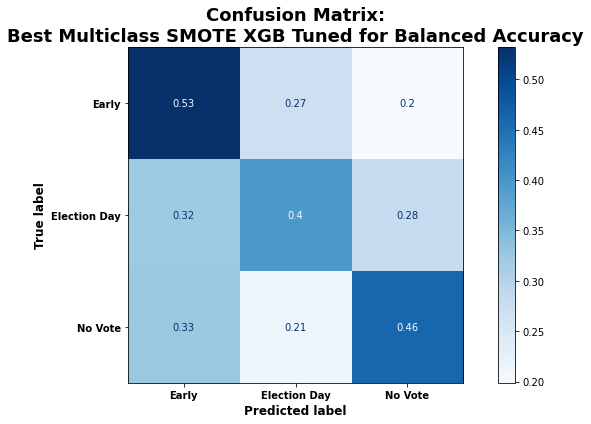

In [140]:
## Define a grid of different hyperparameter values to be tested
params = {
    'sampler__k_neighbors':[3],
    'xgb__eta':[0.1],
    'xgb__max_depth':[6],
    'xgb__subsample': [0.7],
    'xgb__colsample_bytree': [0.8],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_multi_smote_bacc_grid = fit_grid_clf(xgb_multi_smote, params,
                             X_train, y_multi_train,
                             X_test, y_multi_test,
                             model_descr='Best Multiclass SMOTE XGB Tuned for Balanced Accuracy',
                             score='balanced_accuracy')

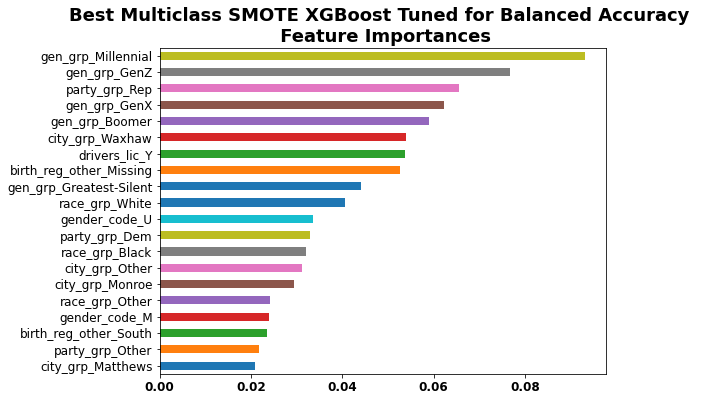

In [141]:
plot_feat_importance(xgb_multi_smote_bacc_grid.best_estimator_, 'xgb', feature_names,
                     model_title='Best Multiclass SMOTE XGBoost Tuned for Balanced Accuracy \n');

# INTERPRET

In [142]:
## Import necessary libraries
import xgboost
import shap

## Load JS visualization code to notebook
shap.initjs()

## Convert transformed (preprocessed) X train set into pandas DataFrame
X_train_df = pd.DataFrame(X_train_tf, columns=feature_names)
X_train_df.head()

,gen_grp_Boomer,gen_grp_GenX,gen_grp_GenZ,gen_grp_Greatest-Silent,gen_grp_Millennial,party_grp_Dem,party_grp_Other,party_grp_Rep,race_grp_Black,race_grp_Other,race_grp_Undesig.,race_grp_White,gender_code_F,gender_code_M,gender_code_U,birth_reg_other_Midwest,birth_reg_other_Missing,birth_reg_other_Northeast,birth_reg_other_Other,birth_reg_other_South,birth_reg_other_West,drivers_lic_Y,city_grp_Indian Trail,city_grp_Matthews,city_grp_Monroe,city_grp_Other,city_grp_Waxhaw
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Binary Target Model

In [143]:
## Store the booster (trained model)
bin_model = xgb_bin_bacc_grid.best_estimator_.named_steps['xgb'].get_booster()

## Explain the model's predictions using SHAP
bin_explainer = shap.TreeExplainer(bin_model)
bin_shap_values = bin_explainer.shap_values(X_train_df)

In [144]:
## Print model prediction for seventh row of training set
print('Prediction: ', 
      xgb_bin_bacc_grid.best_estimator_.named_steps['xgb'].predict(X_train_df.iloc[6,:]))
# (0, no vote)

## Print ground truth label seventh row of training set
print('Actual: ', 
      y_bin_train.iloc[6])
# (0, truly no vote)

## Visualize the seventh prediction's explanation
shap.force_plot(bin_explainer.expected_value,
                bin_shap_values[6,:],
                X_train_df.iloc[6,:])

Prediction:  [0]
Actual:  0


The plot above visualizes how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual did not vote and the model predicted this correctly. The model was pushed towards the prediction of "no vote" by the fact that the individual belongs to Gen Z (and thus is also neither in Generation X or a Baby Boomer). The fact that the individual was male and not a Republican also pushed the model towards the correct prediction for this individual. The facts that he lives in Matthews and is not a millennial pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "no vote" (0).

In [145]:
## Print model prediction for third row of training set
print(xgb_bin_bacc_grid.best_estimator_.named_steps['xgb'].predict(X_train_df.iloc[2,:]))
# (1, voted)

## Print ground truth label third row of training set
print('Actual: ', 
      y_bin_train.iloc[2])
# (1, truly did vote)

## Visualize the third prediction's explanation
shap.force_plot(bin_explainer.expected_value,
                bin_shap_values[2,:],
                X_train_df.iloc[2,:])

[1]
Actual:  1


The plot immediately above visualizes how the model is making its prediction for the third individual in the training set. 
> The third individual voted and the model predicted this correctly. The model was pushed towards the prediction of "vote" (1) by the fact that their birth region information was missing, they belong to the Baby Boomer generation (and thus are not a millenial), and they have a drivers license. The fact the this person is not a Republican and also chose not to identify as being affiliated with either of the two major political parties pushed the model in the incorrect direction towards "no vote" (0), but not enough to overwhelm the factors more predictive of "vote" (1).

The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 7 features (after which there is a drop in impact) are `gen_grp_Millennial`, `birth_reg_other_Missing`, `party_grp_Rep`, `gen_grp_Boomer`, `gen_grp_GenX`, `gen_grp_GenZ`, and `drivers_lic_Y`. Obviously age group is important because it makes up 4 of the top 7 features. Only the oldest age group (really two oldest generations combined as 'Greatest-Silent') is missing. Whether or not a person's voter registration record lists their birthplace is the second most impactful feature on model output, and whether or not the voter registered as a Republican is the third most impactful feature. Whether or not the person possesses a drivers license was the 7th most impactful predictor.

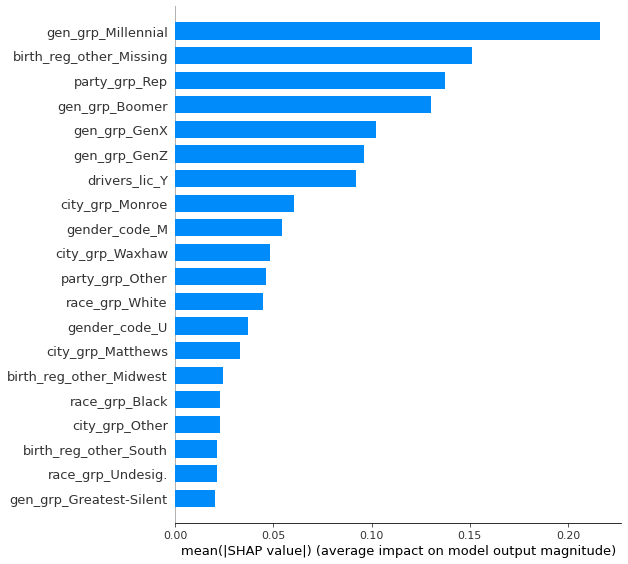

In [146]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_shap_values, X_train_df, plot_type='bar')

The plot below is similar to that above in that it ranks the top features based on mean SHAP values (so the ordering is the same). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election (whether they voted or not). Negative SHAP values to the left of the grey line push the model towards a prediction of 0 or "No Vote" whereas positive SHAP values push the model towards a prediction of 1 or "Vote". 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

**Top 7 Features Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model towards a prediction of "No Vote".


2. `birth_reg_other_Missing` - Voters whose record was missing their birthplace information (1, red) were more likely to vote.


3. `party_grp_Rep` - Being a Republican (1, red) pushed the model towards a prediction of "Vote".


4. `gen_grp_Boomer` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Vote".


5. `gen_grp_GenX` - Belonging to the Generation X (1, red) pushed the model towards a prediction of "Vote".


6. `gen_grp_GenZ` - Belonging to the Gen Z (1, red) pushed the model towards a prediction of "No Vote".


7. `drivers_lic_Y` - Not having a drivers license (0, blue) made the model predict that someone was less likely to vote.

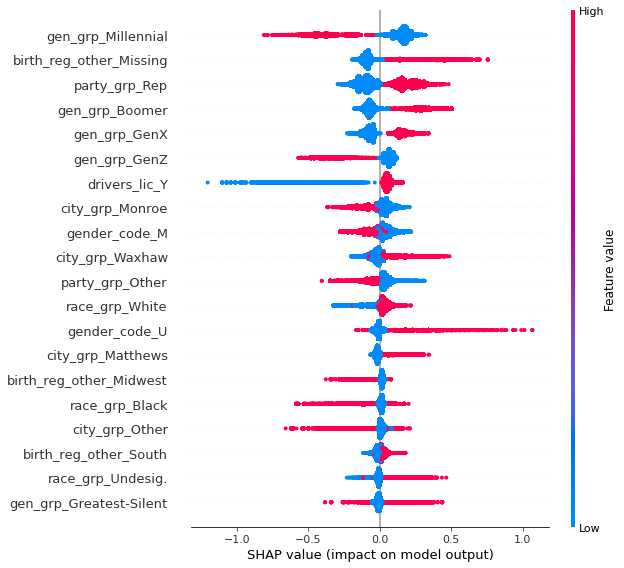

In [147]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_shap_values, X_train_df)

In [148]:
## Take a random sample of the X_train_df and corresponding shap values
  ## for SHAP visuals (can't handle many thousands of obsvs at once)
bin_rand_X1 = X_train_df.sample(1000, random_state=42)
bin_rand_shap1 = bin_shap_values[bin_rand_X1.index,:]

> The plots below show some of the most obvious interaction effects for the top 5 features (`gen_grp_GenZ` and `drivers_lic_Y` did not have any obvious interactions with other features).

>> Millennials that did not disclose their race were not as unlikely to vote as other millennials while non-millennials that did not disclose their race were actually less likely to vote than other non-millennials.

In [149]:
## Create a dependence plot to show the effect of gen_grp_Millennial
shap_dependence('gen_grp_Millennial', bin_rand_shap1, bin_rand_X1)

NameError: name 'shap_dependence' is not defined

> > Baby Boomers with missing birthplace information were potentially more likely to vote than other Baby Boomers. On the other hand, the trend is more clear that non-Baby Boomers with missing birthplace information were actually less likely to vote than their other non-Baby Boomer counterparts who supplied that information.

In [ ]:
## Create a dependence plot to show the effect of gen_grp_Millennial
shap_dependence('birth_reg_other_Missing', bin_rand_shap1, bin_rand_X1)

> > Republicans who live in the city of Monroe seemed even more likely to vote than other Republicans. The trend is less clear for non-Republicans.

In [ ]:
## Create a dependence plot to show the effect of gen_grp_Millennial
shap_dependence('party_grp_Rep', bin_rand_shap1, bin_rand_X1)

> > The trends are not extremely clear in part due to the low number of Black registered voters, but it seems that Baby Boomers who are Black and identified as such when registering were more likely to vote than non-Black Baby Boomers on average. However this trend seems possibly flipped in that Black non-Baby Boomers were even less likely to vote on average than their other non-Boomer counterparts.

In [ ]:
## Create a dependence plot to show the effect of gen_grp_Millennial
shap_dependence('gen_grp_Boomer', bin_rand_shap1, bin_rand_X1)

> > Generation X'ers who live in Waxhaw seemed even more likely to vote than other Generation X'ers. The trend is less clear for non-Gen X'ers.

In [ ]:
## Create a dependence plot to show the effect of gen_grp_GenX
shap_dependence('gen_grp_GenX', bin_rand_shap1, bin_rand_X1)

## Multiclass Target Model

In [ ]:
## Store the booster (trained model)
multi_model = xgb_multi_smote_bacc_grid.best_estimator_.named_steps['xgb'].get_booster()

## Explain the model's predictions using SHAP
multi_explainer = shap.TreeExplainer(multi_model)
multi_shap_values = multi_explainer.shap_values(X_train_df)

In [ ]:
## multi_shap_values is a list of 3 arrays, one for each class
print(type(multi_shap_values))
print(type(multi_shap_values[0]))
print(multi_shap_values[0].shape)
len(multi_shap_values)

In [ ]:
## Check order of label encoded classes
le.classes_

In [ ]:
## Store each class' array of values separately
early_multi_shap = multi_shap_values[0].shape
elec_multi_shap = multi_shap_values[1].shape
no_multi_shap = multi_shap_values[2].shape

In [ ]:
## Print model pred and ground truth label for seventh row of training set
  ## and visualize prediction explanation
multi_shap_force(xgb_multi_smote_bacc_grid.best_estimator_, 'xgb', 6,
                     X_train_df, y_multi_train,
                     multi_explainer, multi_shap_values)

The plots above visualize how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual did not vote and the model predicted this correctly. The breakdown for the "No Vote" class is shown in the third plot. The other two plots show how the features influenced the model's prediction for this person for the other two classes, but in the case of multiclass models, the class with the highest score was ultimately the predicted output for each voter.

> Examining the bottom plot, the model was pushed towards the prediction of "No Vote" by the fact that the individual belongs to Gen Z (and thus is also neither in Generation X or a Baby Boomer). The fact that the individual was not a Republican, is not missing birthplace information, and is a male also pushed the model towards the correct prediction for this individual. The facts that he is white and lives in Matthews pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "No Vote".

In [ ]:
## Print model pred and ground truth label for third row of training set
  ## and visualize prediction explanation
multi_shap_force(xgb_multi_smote_bacc_grid.best_estimator_, 'xgb', 2,
                     X_train_df, y_multi_train,
                     multi_explainer, multi_shap_values)

The plots above visualize how the model is making its prediction for the third individual in the training set. 
> The third individual voted early, but the model predicted that they voted on election day. The breakdown for the "Early" class is shown in the first plot, while that for "Election Day" is in the second plot. For multiclass models, the class with the highest score was ultimately the predicted output for each voter. The score for "Election Day" was only 0.04 greater than the score for "Early".

> Examining the bottom plot, the model was pushed towards the prediction of "Election Day" by the fact that the individual lives in Monroe (and thus does not live in Waxhaw), that their birthplace information is missing in their registration record, and they are not a Democrat or Black. The fact that the individual is not a Generation X'er and is not male or a Republican, is not missing birthplace information, and is a male pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "Election Day".

The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 6 features (after which there is a drop in impact) are `gen_grp_Millennial`, `gen_grp_GenX`, `birth_reg_other_Missing`, `party_grp_Rep`, `gen_grp_Boomer`, and `city_grp_Waxhaw`. These are almost exactly the same top features as for the binary target model, and are in a very similar order. Obviously age group is important because it makes up 3 of the top 6 features. Whether or not a person's voter registration record lists their birthplace is the third most impactful feature on model output, and whether or not the voter registered as a Republican is the fourth most impactful feature. Whether or not the voter resides in Waxhaw was the 6th most impactful predictor. The colors of the bars represent how much the particular feature influenced the prediction for each class, but these trends are more easily visualized in the non-bar summary plots that follow.

In [ ]:
## Display mean abs(SHAP value) of each feature for the full training set
  ## for all classes
shap.summary_plot(multi_shap_values, X_train_df,
                  plot_type='bar', class_names=le.classes_)

The plots that follow are similar to the above plot in that they rank the top features based on mean SHAP values, but each plot ranks the features for one of the 3 target classes ("Early", "Election Day", and then "No Vote" respectively). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election. Negative SHAP values to the left of the grey line push the model towards a prediction of 0 for the particular class (in other words, not the class in question), whereas positive SHAP values push the model towards a prediction of the class in question (1). 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

---

**Top 5 Features for the "Early" Class Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model away from a prediction of "Early".


2. `gen_grp_Boomer` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Early".


3. `city_grp_Monroe` - Residing in Monroe (1, red) pushed the model away from a prediction of "Early".


4. `city_grp_Waxhaw` - Residing in Waxhaw (1, red) pushed the model towards a prediction of "Early".


5. `gen_grp_Greatest-Silent` - Belonging to the Greatest/ Silent generation age group (1, red) pushed the model towards a prediction of "Early".

In [ ]:
multi_shap_summ(multi_shap_values, X_train_df, 0);

---

**Top 5 Features for the "Election Day" Class Explained**:

1. `city_grp_Waxhaw` - Residing in Waxhaw (1, red) pushed the model away from a prediction of "Election Day".


2. `gen_grp_GenX` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Election Day".


3. `drivers_lic_Y` - Not having a drivers license (0, blue) pushed the model away from a prediction of "Election Day".


4. `race_grp_Black` - Being Black (1, red) pushed the model away from a prediction of "Election Day".


5. `party_grp_Dem` - Being a Democrat pushed the model away from a prediction of "Election Day".

In [ ]:
multi_shap_summ(multi_shap_values, X_train_df, 1);

---

**Top 5 Features for the "No Vote" Class Explained**:

1. `birth_reg_other_Missing` - Missing information about birthplace (1, red) pushed the model away from a prediction of "No Vote".


2. `party_grp_Rep` - Being a Republican (1, red) pushed the model away from a prediction of "No Vote" and not being a Republican (0, blue) pushed the model towards a prediction of "No Vote".


3. `gen_grp_GenX` -  Belonging to Generation X (1, red) pushed the model away from a prediction of "No Vote".


4. `gen_grp_Boomer` - Being a Baby Boomer (1, red) pushed the model away from a prediction of "No Vote".


5. `drivers_lic_Y` - Not having a drivers license (0, blue) pushed the model towards a prediction of "No Vote".

In [ ]:
multi_shap_summ(multi_shap_values, X_train_df, 2);

In [ ]:
# ## Take a random sample of the X_train_df and corresponding shap values
#   ## for SHAP visuals (can't handle many thousands of obsvs at once)
# multi_rand_X1 = X_train_df.sample(1000, random_state=42)
# early_rand_shap1 = multi_shap_values[0][multi_rand_X1.index,:]
# elec_rand_shap1 = multi_shap_values[1][multi_rand_X1.index,:]
# no_rand_shap1 = multi_shap_values[2][multi_rand_X1.index,:]
# multi_rand_shap1 = list([early_rand_shap1,
#                              elec_rand_shap1,
#                              no_rand_shap1])

# Conclusions/Recommendations